GravLensing Project code compilation

In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset


from torchvision import datasets, transforms
import torchvision


new Dataset class:

In [2]:
class DatasetFolder:
    def __init__(self, root_dir, transforms):
        self.root_dir=root_dir
        self.transforms=transforms
    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self,index):
        label=os.listdir(self.root_dir)[index]
        fits_path=r''+self.root_dir+'/'+label
        file=fits.getdata(fits_path, ext=0)
        file=file.astype(float)
        file=np.transpose(file, (1,0,2))
        if self.transforms:
            file=self.transforms(file)
        if label[:4]=='lens':
            newlabel='lens'
        else: newlabel='nonlens'
        #print(label)
        return (file, newlabel)

Initialisation of data:

['lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
['nonlens_1', 'nonlens_2', 'nonlens_3', 'nonlens_4', 'nonlens_5']
train dataset: 52200
test dataset: 17400
validation dataset: 17400
408
136
136
mean and std after normalize:
Mean of the image: [-0.6984949  -0.21306813  0.19496664]
Std of the image: [0.58107237 1.65378593 2.81904189]


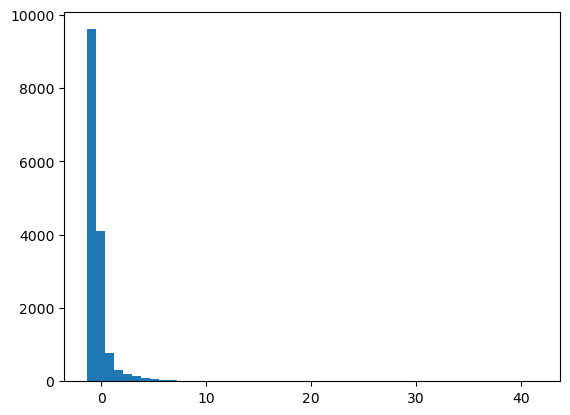

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

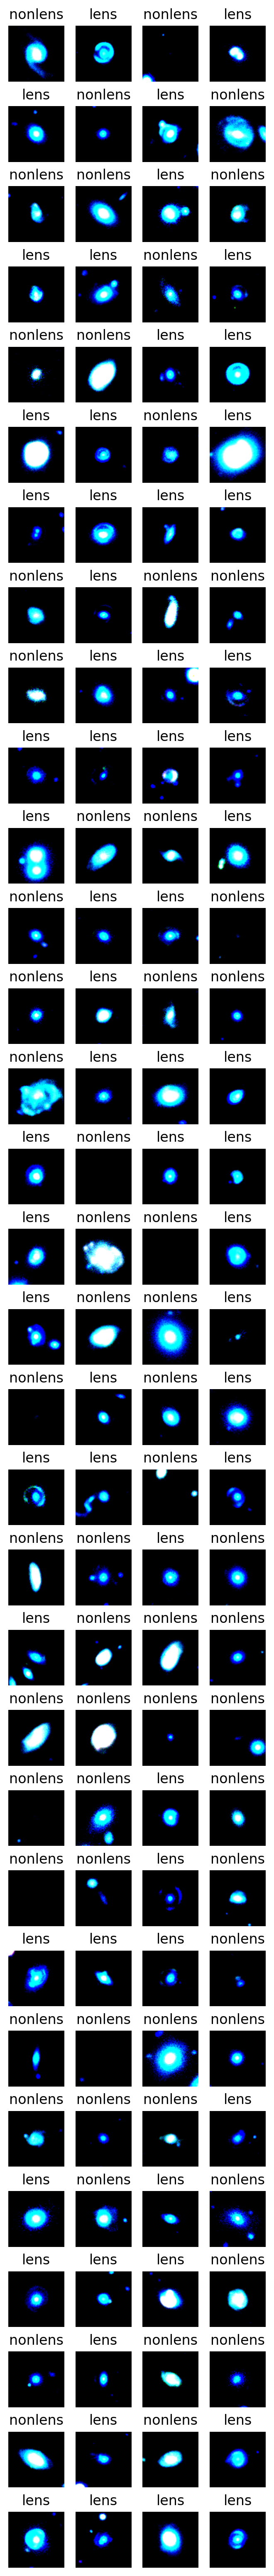

In [3]:
#class Initialisation:
    #main for excluding runtime errors in windows
#def main():

#creating relative path to data for use on different devices
filedir=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/lens'
filedirnon=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/nonlens'
filename1=os.listdir(filedir)
filename1non=os.listdir(filedirnon)
print(filename1) #gives the filenames lens_1 etc.
print(filename1non)

#lenses contains the subfiles of type Datasetfolder
lenses = []
nonlenses=[]

#transforms used on the images
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

for filename in filename1:
    filedir2=r''+filedir+'/'+filename
    filename2=os.listdir(filedir2)
    data=DatasetFolder(filedir2, transform)
    lenses.append(data)
for filenamenon in filename1non:
    filedir2non=r''+filedirnon+'/'+filenamenon
    filename2non=os.listdir(filedir2non)
    datanon=DatasetFolder(filedir2non, transform)
    nonlenses.append(datanon)



#concat all the lenses into one dataset
image_dataset = torch.utils.data.ConcatDataset(lenses)
image_dataset_non = torch.utils.data.ConcatDataset(nonlenses)
arr=[image_dataset, image_dataset_non]
total =torch.torch.utils.data.ConcatDataset(arr)

#splitting the images:
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(total, [int(0.6*len(total)), int(0.2*len(total)), int(0.2*len(total))])


print('train dataset:', len(train_dataset))
print('test dataset:', len(test_dataset))
print('validation dataset:', len(validation_dataset))
#-> 1: image, 2:pixel number, 3: which of the 3 channels

#trainloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, shuffle=True)
#%store trainloader #magic command to store the variable so that we can use it later
classes=('lens', 'nonlens')

#np.einsum('kij->ijk',train_dataset)
print(len(trainloader)) #returns 408-> accounts for number of images in the files!!!
print(len(testloader))
print(len(validationloader))

#iterate over trainloader
#target[i][j][k][m]: i:image channel (3) OR maybe image, label? ????, j: number of batch (64), k: pixel number (up to 72), m: up to 3 (RGB)
target=next(iter(trainloader))
#target[0]-> image, target[1]-> label

#show images
fig=plt.figure()

#sanity check with image -> definetely more normalized, but completely? ~~~
#imageRGB_reshape = np.einsum('ikj->ijk',target[0][0])
img_np = np.array(target[0][0])
mean, std = np.mean(img_np, axis=(0, 1)), np.std(img_np, axis=(0, 1))
print("mean and std after normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std) 
plt.hist(img_np.ravel(), bins=50)
plt.show()

_, axs= plt.subplots(32,4, figsize=(4, 40), dpi=200) #figsize=(12, 12)
axs = axs.flatten()
for img, ax, labels in zip(target[0], axs, target[1]):
    ax.imshow(img)
    ax.set_title(labels)
    ax.axis('off')
#for j in range(128):
#    axarr[j].imshow(target[0][j])
#print('  '.join(target[1][j] for j in range(128)))

#if __name__=='__main__':
#    main()
        

Creating the model of the Network Net

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel (I,R,B), 6 output channels, 3x3 square convolution
        #16 layers of convolution followed by a fully connected linear and an output layer

        self.conv11 = nn.Conv2d(3, 6, 3)
        self.conv12 = nn.Conv2d(6, 16, 3)

        self.conv21 = nn.Conv2d(1, 6, 3)
        self.conv22 = nn.Conv2d(6, 16, 3)

        self.conv31 = nn.Conv2d(1, 6, 3)
        self.conv32 = nn.Conv2d(6, 16, 3)

        self.conv41 = nn.Conv2d(16, 16, 3)
        self.conv42 = nn.Conv2d(16, 16, 3)

        self.conv51 = nn.Conv2d(16, 16, 3)
        self.conv52 = nn.Conv2d(16, 16, 3)

        self.conv61 = nn.Conv2d(16, 16, 3)
        self.conv62 = nn.Conv2d(16, 16, 3)

        self.conv71 = nn.Conv2d(16, 16, 3)
        self.conv72 = nn.Conv2d(16, 16, 3)

        self.conv81 = nn.Conv2d(16, 16, 3)
        self.conv82 = nn.Conv2d(16, 16, 3)

        self.fc1 = nn.Linear(16 * 72 * 72, 16)  # 6*6 from image dimension
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        # ReLu convolution over a (2, 2) window
        x = F.relu(self.conv11(x), (2, 2))
        x = F.relu(self.conv12(x), (2, 2))
        x = F.relu(self.conv21(x), (2, 2))
        x = F.relu(self.conv22(x), (2, 2))
        x = F.relu(self.conv31(x), (2, 2))
        x = F.relu(self.conv32(x), (2, 2))
        x = F.relu(self.conv41(x), (2, 2))
        x = F.relu(self.conv42(x), (2, 2))
        x = F.relu(self.conv51(x), (2, 2))
        x = F.relu(self.conv52(x), (2, 2))
        x = F.relu(self.conv61(x), (2, 2))
        x = F.relu(self.conv62(x), (2, 2))
        x = F.relu(self.conv71(x), (2, 2))
        x = F.relu(self.conv72(x), (2, 2))
        x = F.relu(self.conv81(x), (2, 2))
        x = F.relu(self.conv82(x), (2, 2))
    
        #x = x.view(-1, self.num_flat_features(x)) ---> what is this?
        #final fully connected linear layers with ReLu and sigmoid
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    #no idea what this does...
    '''
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features'''
#creating the model on device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model=Net().to(device)
print(model)

Using cpu device
Net(
  (conv11): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv21): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv22): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv31): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv32): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv41): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv42): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv51): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv52): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv61): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv62): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv71): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv72): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv81): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv82): Conv2d(16, 16, kernel_size=(3, 3), stride=(1,

Loss Function: Cross entropy

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 2)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 0, 0, 0])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.6976, 0.8389],
        [0.1135, 0.4088],
        [0.7982, 0.1980],
        [0.9311, 0.7319]])
tensor([1, 0, 0, 0])
Total loss for this batch: 0.6281289458274841


Optimizer: Stochastic gradient descent

In [6]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9, weight_decay=0.001)

Training loop over 100 epochs

In [18]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs=inputs.float()
        inputs_reshape = torch.from_numpy(np.einsum('...ijk->...kij',inputs))
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs_reshape)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report loss for every 1000 batches
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

Per-Epoch Activity: validation, save copy of model

In [19]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validationloader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


RuntimeError: Given groups=1, weight of size [6, 1, 3, 3], expected input[128, 16, 68, 68] to have 1 channels, but got 16 channels instead

load model:

In [ ]:
#saved_model = Net()
#saved_model.load_state_dict(torch.load(PATH))